# Plotting animated GIFs from time series imagery

**What does this notebook do?** 

This notebook demonstrates how to import a time series of DEA cloud-free Landsat imagery from multiple sensors (i.e. Landsat 5, 7 and 8) as an xarray dataset, and then plot the data as an animated time series GIF and a transitioning/fading GIF that compares two timesteps. Animations can be produced as either GIFs or MP4s for any area in Australia using a standard datacube query.

**Required inputs**

This example uses three external functions called `load_clearlandsat`, `animated_timeseries` and `animated_fade`. These functions are available in the Scripts folder of the [dea-notebooks Github repository](https://github.com/GeoscienceAustralia/dea-notebooks/tree/master/Scripts). Note that these functions have been developed by DEA users, not the DEA development team, and so are provided without warranty. If you find an error or bug in the functions, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated function back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** May 2018

**Author:** Robbi Bishop-Taylor

In [139]:
# Import modules
import datacube 
import sys

# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('../Scripts')
import DEADataHandling
import DEAPlotting

# Set up datacube instance
dc = datacube.Datacube(app='Time series animation')
# dc = datacube.Datacube(config='/home/561/rt1527/preprod_dc.conf')



## Set up datacube query
Define the query bounds for datacube extraction using a dict. This should include `x` and `y` limits, potentially a list of `measurements` (i.e. the bands you want to extract like 'red', 'green', 'blue'; this significantly speeds up the import) and a `time` extent. If no `time` is given, the function defaults to all timesteps available to all sensors (e.g. 1987-2018).

In [363]:
from datacube.utils import geometry
from datacube.utils.geometry import CRS

# Set up analysis data query using a buffer around a lat-long point
lat, lon, buffer = -35.712572416, 150.115577708, 6500
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('2000-01-01', '2016-12-30'),
         'crs': 'EPSG:3577'}


## Extract cloud-free clear Landsat observations from all sensors
Use the `load_clearlandsat` function to load Landsat observations and PQ data for multiple sensors (i.e. ls5, ls7, ls8), and return a single xarray dataset containing only observations that contain greater than a specified proportion of clear pixels. This uses `dask` to only load in the filtered observations, and results in a visually appealing time series of observations that are not affected by cloud!

In [409]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patheffects as PathEffects
import calendar


def animated_doubletimeseries(ds1, ds2, output_path, width_pixels=800, interval=100, 
                              bands1=['red', 'green', 'blue'], bands2=['red', 'green', 'blue'], 
                              reflect_stand1=5000, reflect_stand2=5000, 
                              title1=False, title2=False,
                              show_date1=True, show_date2=True,
                              onebandplot_kwargs1={}, onebandplot_kwargs2={},
                              annotation_kwargs1={}, annotation_kwargs2={}):
    
    """
    Takes two xarray time series and animates both side-by-side as either three-band (e.g. true or false colour) 
    or single-band animations, allowing changes in the landscape to be compared across time.
    
    Animations can be exported as .mp4 (ideal for Twitter/social media), .wmv (ideal for Powerpoint) and .gif 
    (ideal for all purposes, but can have large file sizes) format files, and customised to include titles and 
    date annotations for each panel or use different input bands from each dataset. For example, true and false 
    colour band combinations could be plotted at the same time, or different products (i.e. NBAR and NBART) or 
    cloud masking algorithms could be compared. 
    
    This function can be used to produce visually appealing cloud-free animations when used in combination with 
    the `load_clearlandsat` function from `dea-notebooks/Scripts/DEADataHandling`.
    
    Last modified: May 2018
    Author: Robbi Bishop-Taylor    
    
    :param ds1: 
        An xarray dataset with multiple time steps (i.e. multiple observations along the `time` dimension) to be 
        plotted in the left panel of the animation.
        
    :param ds2: 
        A matching xarray dataset with the same number of pixels as ds1, to be plotted in the right panel of the
        animation. ds1 and ds2 do not need to have exactly the same number of timesteps, but the animation will 
        only continue up until the length of the shorted dataset (i.e. if ds1 has 10 timesteps and ds2 has 5, the 
        animation will continue for 5 timesteps).
        
    :param output_path: 
        A string giving the output location and filename of the resulting animation. File extensions of '.mp4', 
        '.wmv' and '.gif' are accepted.
        
    :param width_pixels:
        An optional integer defining the output width in pixels for the resulting animation. The height of the 
        animation is set automatically based on the dimensions/ratio of `ds1`. Defaults to 
        800 pixels wide.
        
    :param interval:
        An optional integer defining the milliseconds between each animation frame used to control the speed of 
        the output animation. Higher values result in a slower animation. Defaults to 100 milliseconds between 
        each frame.
        
    :param bands1:
        An optional list of either one or three bands to be plotted, all of which must exist in `ds1`.
        Defaults to `['red', 'green', 'blue']`.
    
    :param bands2:
        An optional list of either one or three bands to be plotted, all of which must exist in `ds2`.
        Defaults to `['red', 'green', 'blue']`. 
        
    :param reflect_stand1:
        An optional  integer controlling the brightness of the output `ds1` image. Low values (< 5000) result in 
        brighter images. Defaults to 5000.
    
    :param reflect_stand2:
        An optional integer controlling the brightness of the output `ds2` image. Low values (< 5000) result in 
        brighter images. Defaults to 5000.

    :param title1: 
        An optional string or list of strings with a length equal to the number of timesteps in `ds1`. This can be
        used to display a static title for the left panel (using a string), or a dynamic title (using a list)
        that displays different text for each timestep. Defaults to False, which plots no title.
        
    :param title2: 
        An optional string or list of strings with a length equal to the number of timesteps in `ds2`. This can be
        used to display a static title for the left panel (using a string), or a dynamic title (using a list)
        that displays different text for each timestep. Defaults to False, which plots no title.
        
    :param show_date1:
        An optional boolean that defines whether or not to plot date annotations for each animation frame in the 
        left panel. Defaults to True, which plots date annotations for `ds1`.
    
    :param show_date2:
        An optional boolean that defines whether or not to plot date annotations for each animation frame in the 
        right panel. Defaults to True, which plots date annotations for `ds2`.
        
    :param onebandplot_kwargs1:
        An optional dict of kwargs for controlling the appearance of `ds1` one-band image arrays to pass to 
        matplotlib `plt.imshow` (see https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html for options).
        This only applies if an xarray with a single band is passed to d1. For example, a green colour scheme and
        custom stretch can be specified using: `onebandplot_kwargs1={'cmap':'Greens`, 'vmin':0.2, 'vmax':0.9}`. 
        By default, one-band arrays are plotted using the 'Greys' cmap with a vmin of 0.0 and a vmax of 1.0.
    
    :param onebandplot_kwargs2:
        An optional dict of kwargs for controlling the appearance of `ds2` one-band image arrays to 
        pass to matplotlib `plt.imshow`; only applies if an xarray with a single band is passed to d2 (see above).
    
    :param annotation_kwargs1:
        An optional dict of kwargs for controlling the appearance of `ds1` text annotations to pass to 
        matplotlib `plt.annotate`  (see https://matplotlib.org/api/_as_gen/matplotlib.pyplot.annotate.html). 
        For example, `annotation_kwargs1={'fontsize':20, 'color':'red', 'family':'serif'}. By default, text 
        annotations are white, size 15 mono-spaced font with a 3pt black outline in the panel's top-right. 
    
    :param annotation_kwargs2:
        An optional dict of kwargs for controlling the appearance of the `ds2` text annotations to pass 
        to matplotlib `plt.annotate` (see above).
        
    """

    # Define function to convert xarray dataset to list of three band numpy arrays
    def _ds_to_arrraylist(ds, bands, reflect_stand):   

        array_list = []
        for i, timestep in enumerate(ds.time):

            # Select single timestep from the data array
            ds_i = ds.isel(time = i)

            # Create new three band array
            y, x = ds_i[bands[0]].shape

            if len(bands) == 1:    

                # Create new three band array
                img_toshow = ds_i[bands[0]].values

            else:

                rawimg = np.zeros((y, x, 3), dtype=np.float32)

                # Add xarray bands into three dimensional numpy array
                for band, colour in enumerate(bands):

                    rawimg[:, :, band] = ds_i[colour].values

                # Stretch contrast using defined reflectance standardisation; defaults to 5000
                img_toshow = (rawimg / reflect_stand).clip(0, 1)

            array_list.append(img_toshow)

        return(array_list)
    
    
    ###############
    # Setup steps #
    ############### 
    
    # Get height relative to a size of 10 inches width
    width_ratio = float(ds1.sizes['x']) / float(ds1.sizes['y'])
    height = 10.0 / width_ratio
    
    # Get number of timesteps for each dataset
    timesteps1 = len(ds1.time)
    timesteps2 = len(ds2.time)
    
    # If title is supplied as a string, multiply out to a list with one string per timestep.
    # Otherwise, use supplied list for plot titles.
    if isinstance(title1, str) or isinstance(title1, bool):
        title_list1 = [title1] * timesteps1   
    else:
        title_list1 = title1
        
    # If title is supplied as a string, multiply out to a list with one string per timestep
    if isinstance(title2, str) or isinstance(title2, bool):
        title_list2 = [title2] * timesteps2  
    else:
        title_list2 = title2       
        
    # Set up annotation parameters that plt.imshow plotting for single band array images. 
    # The nested dict structure sets default values which can be overwritten/customised by the 
    # manually specified `onebandplot_kwargs`
    onebandplot_kwargs1 = dict({'cmap':'Greys', 'vmin':0.0, 'vmax':1.0, 'interpolation':'bilinear'},
                                **onebandplot_kwargs1) 
    
    onebandplot_kwargs2 = dict({'cmap':'Greys', 'vmin':0.0, 'vmax':1.0, 'interpolation':'bilinear'},
                                **onebandplot_kwargs2) 
    
    # Set up annotation parameters that control font etc. The nested dict structure sets default 
    # values which can be overwritten/customised by the manually specified `annotation_kwargs`
    annotation_kwargs1 = dict({'xy': (1, 1), 'xycoords':'axes fraction', 
                               'xytext':(-5, -5), 'textcoords':'offset points', 
                               'horizontalalignment':'right', 'verticalalignment':'top', 
                               'fontsize':15, 'color':'white', 'family':'monospace', 
                               'path_effects':[PathEffects.withStroke(linewidth=3, foreground='black')]},
                               **annotation_kwargs1)
    
    annotation_kwargs2 = dict({'xy': (1, 1), 'xycoords':'axes fraction', 
                               'xytext':(-5, -5), 'textcoords':'offset points', 
                               'horizontalalignment':'right', 'verticalalignment':'top', 
                               'fontsize':15, 'color':'white', 'family':'monospace', 
                               'path_effects':[PathEffects.withStroke(linewidth=3, foreground='black')]},
                               **annotation_kwargs2)
   
    
    ###################
    # Initialise plot #
    ################### 
    
    # First test if there are three bands, and that all exist in both datasets:
    if ((len(bands1) == 3) | (len(bands1) == 1)) & all([(b1 in ds1.data_vars) for b1 in bands1]) & \
       ((len(bands2) == 3) | (len(bands2) == 1)) & all([(b2 in ds2.data_vars) for b2 in bands2]):  

        # Import xarrays as lists of three band numpy arrays
        imagelist1 = _ds_to_arrraylist(ds1, bands=bands1, reflect_stand=reflect_stand1)
        imagelist2 = _ds_to_arrraylist(ds2, bands=bands2, reflect_stand=reflect_stand2)
        
        # Test that shapes are the same:
        if imagelist1[0].shape[0:1] == imagelist2[0].shape[0:1]:
            
            # Set up figure
            fig, (ax1, ax2) = plt.subplots(ncols=2) 
            fig.patch.set_facecolor('black')
            fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
            fig.set_size_inches(10.0, height * 0.5, forward=True)
            ax1.axis('off')
            ax2.axis('off')

            # Initialise axesimage objects to be updated during animation
            left, bottom, right, top = ds1.extent.boundingbox
            im1 = ax1.imshow(imagelist1[0], extent=[left, right, bottom, top], **onebandplot_kwargs1)
            left, bottom, right, top = ds2.extent.boundingbox
            im2 = ax2.imshow(imagelist2[0], extent=[left, right, bottom, top], **onebandplot_kwargs2)

            # Initialise annotation objects to be updated during animation
            t1 = ax1.annotate('', **annotation_kwargs1)   
            t2 = ax2.annotate('', **annotation_kwargs2)  

            # Function to update figure
            def update_figure(frame_i):

                ####################
                # Plot first panel #
                ####################  

                # Get human-readable date info (e.g. "16 May 1990")
                ts = ds1.time.isel(time=frame_i).dt
                year = ts.year.item()
                month = ts.month.item()
                day = ts.day.item()

                # Create annotation string based on title and date specifications:
                title1 = title_list1[frame_i]
                if title1 and show_date1:
                    title_date1 = '{} {} {}\n{}'.format(day, calendar.month_abbr[month], year, title1)
                elif title1 and not show_date1:
                    title_date1 = '{}'.format(title1)
                elif show_date1 and not title1:
                    title_date1 = '{} {} {}'.format(day, calendar.month_abbr[month], year)           
                else:
                    title_date1 = ''

                # Update figure for frame
                im1.set_array(imagelist1[frame_i])
                t1.set_text(title_date1) 


                #####################
                # Plot second panel #
                ##################### 

                # Get human-readable date info (e.g. "16 May 1990")
                ts = ds2.time.isel(time=frame_i).dt
                year = ts.year.item()
                month = ts.month.item()
                day = ts.day.item()

                # Create annotation string based on title and date specifications:
                title2 = title_list2[frame_i]
                if title2 and show_date2:
                    title_date2 = '{} {} {}\n{}'.format(day, calendar.month_abbr[month], year, title2)
                elif title2 and not show_date2:
                    title_date2 = '{}'.format(title2)
                elif show_date2 and not title2:
                    title_date2 = '{} {} {}'.format(day, calendar.month_abbr[month], year)           
                else:
                    title_date2 = ''

                # Update figure for frame
                im2.set_array(imagelist2[frame_i])
                t2.set_text(title_date2) 

                # Return the artists set
                return [im1, im2, t1, t2]


            ##############################
            # Generate and run animation #
            ##############################

            # Generate animation
            frames_to_run = min(timesteps1, timesteps2)
            print('Generating {} frame animation (i.e. timesteps in shortest dataset)'.format(frames_to_run))
            ani = animation.FuncAnimation(fig, update_figure, frames=frames_to_run, interval=interval, blit=True)

            # Export as either MP4 or GIF
            if output_path[-3:] == 'mp4':
                print('    Exporting animation to {}'.format(output_path))
                ani.save(output_path, dpi=width_pixels / 10.0)

            elif output_path[-3:] == 'wmv':
                print('    Exporting animation to {}'.format(output_path))
                ani.save(output_path, dpi=width_pixels / 10.0, 
                         writer=animation.FFMpegFileWriter(fps=1000 / interval, bitrate=6000, codec='wmv2'))

            elif output_path[-3:] == 'gif':
                print('    Exporting animation to {}'.format(output_path))
                ani.save(output_path, dpi=width_pixels / 10.0, writer='imagemagick')

            else:
                print('    Output file type must be either .mp4, .wmv or .gif')
        
        else:
            print('Ensure that ds1 {} has the same xy dimensions as ds2 {}'.format(imagelist1[0].shape[0:1], 
                                                                                   imagelist2[0].shape[0:1])) 
    else:        
        print('Please select exactly three bands that exist in the input datasets')    


        
        
def animated_timeseries(ds, output_path, width_pixels=400, interval=100, bands=['red', 'green', 'blue'], 
                        reflect_stand=5000, title=False, show_date=True, onebandplot_kwargs={}, annotation_kwargs={}):
    
    """
    Takes an xarray time series and animates the data as either a three-band (e.g. true or false colour) 
    or single-band animation, allowing changes in the landscape to be compared across time.
    
    Animations can be exported as .mp4 (ideal for Twitter/social media), .wmv (ideal for Powerpoint) and .gif 
    (ideal for all purposes, but can have large file sizes) format files, and customised to include titles and 
    date annotations or use specific combinations of input bands. 
    
    This function can be used to produce visually appealing cloud-free animations when used in combination with 
    the `load_clearlandsat` function from `dea-notebooks/Scripts/DEADataHandling`.
    
    Last modified: May 2018
    Author: Robbi Bishop-Taylor    
    
    :param ds: 
        An xarray dataset with multiple time steps (i.e. multiple observations along the `time` dimension).
        
    :param output_path: 
        A string giving the output location and filename of the resulting animation. File extensions of '.mp4', 
        '.wmv' and '.gif' are accepted.
    
    :param width_pixels:
        An integer defining the output width in pixels for the resulting animation. The height of the animation is
        set automatically based on the dimensions/ratio of the input xarray dataset. Defaults to 400 pixels wide.
        
    :param interval:
        An integer defining the milliseconds between each animation frame used to control the speed of the output
        animation. Higher values result in a slower animation. Defaults to 100 milliseconds between each frame. 
        
    :param bands:
        An optional list of either one or three bands to be plotted, all of which must exist in `ds`.
        Defaults to `['red', 'green', 'blue']`. 
        
    :param reflect_stand:
        An optional  integer controlling the brightness of the output image. Low values (< 5000) result in 
        brighter images. Defaults to 5000.

    :param title: 
        An optional string or list of strings with a length equal to the number of timesteps in ds. This can be
        used to display a static title (using a string), or a dynamic title (using a list) that displays different
        text for each timestep. Defaults to False, which plots no title.
        
    :param show_date:
        An optional boolean that defines whether or not to plot date annotations for each animation frame. Defaults 
        to True, which plots date annotations based on ds.
        
    :param onebandplot_kwargs:
        An optional dict of kwargs for controlling the appearance of one-band image arrays to pass to matplotlib 
        `plt.imshow` (see https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html for options).
        This only applies if an xarray with a single band is passed to `ds`. For example, a green colour scheme and
        custom stretch could be specified using: `onebandplot_kwargs={'cmap':'Greens`, 'vmin':0.2, 'vmax':0.9}`. 
        By default, one-band arrays are plotted using the 'Greys' cmap with a vmin of 0.0 and a vmax of 1.0.
    
    :param annotation_kwargs:
        An optional dict of kwargs for controlling the appearance of text annotations to pass to the matplotlib 
        `plt.annotate` function (see https://matplotlib.org/api/_as_gen/matplotlib.pyplot.annotate.html for options). 
        For example, `annotation_kwargs={'fontsize':20, 'color':'red', 'family':'serif'}. By default, text annotations 
        are plotted as white, size 25 mono-spaced font with a 4pt black outline in the top-right of the animation.   
    """

    # Define function to convert xarray dataset to list of three band numpy arrays
    def _ds_to_arrraylist(ds, bands, reflect_stand):   

        array_list = []
        for i, timestep in enumerate(ds.time):

            # Select single timestep from the data array
            ds_i = ds.isel(time = i)

            # Create new three band array
            y, x = ds_i[bands[0]].shape

            if len(bands) == 1:    

                # Create new three band array
                img_toshow = ds_i[bands[0]].values

            else:

                rawimg = np.zeros((y, x, 3), dtype=np.float32)

                # Add xarray bands into three dimensional numpy array
                for band, colour in enumerate(bands):

                    rawimg[:, :, band] = ds_i[colour].values

                # Stretch contrast using defined reflectance standardisation; defaults to 5000
                img_toshow = (rawimg / reflect_stand).clip(0, 1)

            array_list.append(img_toshow)

        return(array_list)
    
    
    ###############
    # Setup steps #
    ############### 
    
    # Get number of timesteps for each dataset
    timesteps = len(ds.time)
    
    # If title is supplied as a string, multiply out to a list with one string per timestep.
    # Otherwise, use supplied list for plot titles.
    if isinstance(title, str) or isinstance(title, bool):
        title_list = [title] * timesteps 
    else:
        title_list = title
    
    # Set up annotation parameters that plt.imshow plotting for single band array images. 
    # The nested dict structure sets default values which can be overwritten/customised by the 
    # manually specified `onebandplot_kwargs`
    onebandplot_kwargs = dict({'cmap':'Greys', 'vmin':0.0, 'vmax':1.0, 'interpolation':'bilinear'},
                               **onebandplot_kwargs)         
    
    # Set up annotation parameters that control font etc. The nested dict structure sets default 
    # values which can be overwritten/customised by the manually specified `annotation_kwargs`
    annotation_kwargs = dict({'xy': (1, 1), 'xycoords':'axes fraction', 
                              'xytext':(-5, -5), 'textcoords':'offset points', 
                              'horizontalalignment':'right', 'verticalalignment':'top', 
                              'fontsize':25, 'color':'white', 'family':'monospace', 
                              'path_effects':[PathEffects.withStroke(linewidth=4, foreground='black')]},
                              **annotation_kwargs)
   
    
    ###################
    # Initialise plot #
    ################### 
    
    # First test if there are three bands, and that all exist in both datasets:
    if ((len(bands) == 3) | (len(bands) == 1)) & all([(b in ds.data_vars) for b in bands]): 
        
        # Get height relative to a size of 10 inches width
        width_ratio = float(ds.sizes['x']) / float(ds.sizes['y'])
        height = 10.0 / width_ratio

        # Import xarrays as lists of three band numpy arrays
        imagelist = _ds_to_arrraylist(ds, bands=bands, reflect_stand=reflect_stand)        

        # Set up figure
        fig, ax1 = plt.subplots(ncols=1) 
        fig.patch.set_facecolor('black')
        fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
        fig.set_size_inches(10.0, height, forward=True)
        ax1.axis('off')

        # Initialise axesimage objects to be updated during animation
        left, bottom, right, top = ds.extent.boundingbox
        im = ax1.imshow(imagelist[0], extent=[left, right, bottom, top], **onebandplot_kwargs)

        # Initialise annotation objects to be updated during animation
        t = ax1.annotate('', **annotation_kwargs)

        # Function to update figure
        def update_figure(frame_i):

            ####################
            # Plot first panel #
            ####################  

            # Get human-readable date info (e.g. "16 May 1990")
            ts = ds.time.isel(time=frame_i).dt
            year = ts.year.item()
            month = ts.month.item()
            day = ts.day.item()

            # Create annotation string based on title and date specifications:
            title = title_list[frame_i]
            if title and show_date:
                title_date = '{} {} {}\n{}'.format(day, calendar.month_abbr[month], year, title)
            elif title1 and not show_date:
                title_date = '{}'.format(title)
            elif show_date and not title:
                title_date = '{} {} {}'.format(day, calendar.month_abbr[month], year)           
            else:
                title_date = ''

            # Update figure for frame
            im.set_array(imagelist[frame_i])
            t.set_text(title_date) 

            # Return the artists set
            return [im, t]


        ##############################
        # Generate and run animation #
        ##############################

        # Generate animation
        print('Generating {} frame animation'.format(timesteps))
        ani = animation.FuncAnimation(fig, update_figure, frames=timesteps, interval=interval, blit=True)

        # Export as either MP4 or GIF
        if output_path[-3:] == 'mp4':
            print('    Exporting animation to {}'.format(output_path))
            ani.save(output_path, dpi=width_pixels / 10.0)

        elif output_path[-3:] == 'wmv':
            print('    Exporting animation to {}'.format(output_path))
            ani.save(output_path, dpi=width_pixels / 10.0, 
                     writer=animation.FFMpegFileWriter(fps=1000 / interval, bitrate=6000, codec='wmv2'))

        elif output_path[-3:] == 'gif':
            print('    Exporting animation to {}'.format(output_path))
            ani.save(output_path, dpi=width_pixels / 10.0, writer='imagemagick')

        else:
            print('    Output file type must be either .mp4, .wmv or .gif')

    else:        
        print('Please select exactly three bands that exist in the input datasets')   
        

Generating 201 frame animation (i.e. timesteps in shortest dataset)
    Exporting animation to /home/561/rt1527/Transfer/animation_double.mp4


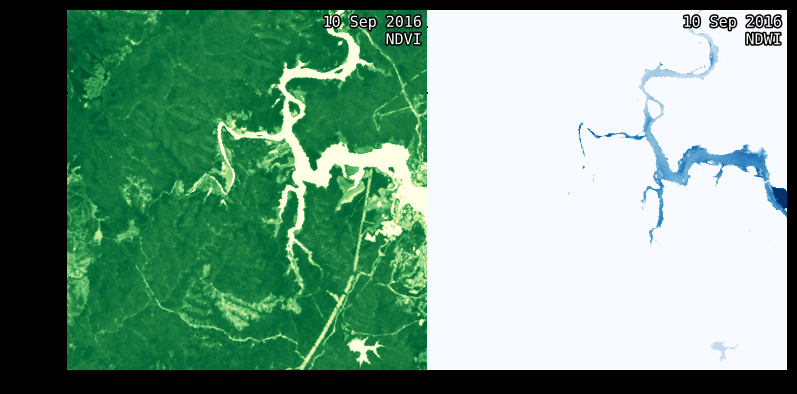

In [410]:
# Custom mask that includes only cloudy or cloud shadowed pixels with data for all bands
custom_mask = {'cloud_acca': 'no_cloud', 
               'cloud_fmask': 'no_cloud', 
               'cloud_shadow_acca': 'no_cloud_shadow',
               'cloud_shadow_fmask': 'no_cloud_shadow',
               'contiguous': True}

# # Load in data
# ds1 = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart', 
#                                         bands_of_interest=['red', 'green', 'blue', 'nir'], 
#                                         masked_prop=0.99, mask_dict=custom_mask, apply_mask=True)  
# ds2 = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart', 
#                                         bands_of_interest=['red', 'green', 'blue', 'nir'], 
#                                         masked_prop=0.99, mask_dict=custom_mask, apply_mask=True) 

# Create custom annotation
# title1 = ['{}% cloud'.format(100 - int(i * 100)) for i in ds1.data_perc.values.tolist()]
ds1['ndvi'] = (ds1.nir - ds1.red) / (ds1.nir + ds1.red)
ds2['ndwi'] = (ds2.green - ds2.nir) / (ds2.green + ds2.nir)


# Animate datasets    
animated_doubletimeseries(ds1=ds1, ds2=ds2, 
                          output_path='/home/561/rt1527/Transfer/animation_double.mp4',
                          bands1=['ndvi'], bands2=['ndwi'], 
                          reflect_stand1=1500, reflect_stand2=1500, 
                          title1="NDVI", title2="NDWI",
                          onebandplot_kwargs1={'cmap':'YlGn', 'vmin':0.2, 'vmax':0.9},
                          onebandplot_kwargs2={'cmap':'Blues', 'vmin':0.0, 'vmax':0.5})

# animated_timeseries(ds=ds1,  
#                     output_path='/home/561/rt1527/Transfer/animation_single.mp4',
#                     bands=['ndvi'], reflect_stand=3000, title=False, 
#                     show_date=True, onebandplot_kwargs={'cmap':'YlGn', 'vmin':0.2, 'vmax':0.9})


In [299]:
ds1['test'] = 0
ds1['test2'] = 50
ds1

animated_timeseries(ds=ds1,  
                    output_path='/home/561/rt1527/Transfer/animation_single.mp4',
                    bands=['test', 'blue', 'test2'], reflect_stand=1000, title=title1, 
                    show_date=True, interval=100)

ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
query = {'x': (1625908, 1638908),
         'y': (-4023753, -4010753),    
         'time': ('2015-01-01', '2016-12-30'),
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:4326', 
         'resolution': (0.000278, 0.000278)}

dc.load(product="ls8_level1_scene", **query)
# y +buffer

In [ ]:
lat, lon = -35.7088156139, 150.121438256

query = {'x': (lon - 0.1, lon + 0.1),
         'y': (lat + 0.1, lat - 0.1),    
         'time': ('2015-01-01', '2016-12-30'),
         'output_crs': 'EPSG:4326',
         'resolution': (0.000278, 0.000278)}

dc.load(product="ls8_level1_scene", **query)

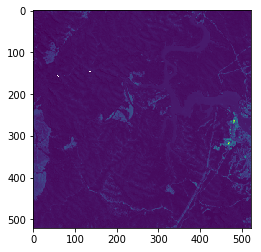

In [327]:
def _ds_to_arrraylist(ds, bands, reflect_stand):   

    array_list = []
    for i, timestep in enumerate(ds.time):

        # Select single timestep from the data array
        ds_i = ds.isel(time = i)

        # Create new three band array
        y, x = ds_i[bands[0]].shape

        if len(bands) == 1:    

            # Create new three band array
            img_toshow = ds_i[bands[0]].values

        else:

            rawimg = np.zeros((y, x, 3), dtype=np.float32)

            # Add xarray bands into three dimensional numpy array
            for band, colour in enumerate(bands):

                rawimg[:, :, band] = ds_i[colour].values

            # Stretch contrast using defined reflectance standardisation; defaults to 5000
            img_toshow = (rawimg / reflect_stand).clip(0, 1)

        array_list.append(img_toshow)

    return(array_list)




In [322]:
bands=["red"]

ds = ds1[["red"]]





# Select single timestep from the data array
ds_i = ds.isel(time = 0)

# Create new three band array
img_toshow = ds_i[bands[0]].values
img_toshow

array([[ 419.,  402.,  400., ...,  244.,  269.,  310.],
       [ 431.,  428.,  389., ...,  248.,  246.,  295.],
       [ 464.,  378.,  358., ...,  230.,  352.,  595.],
       ...,
       [ 315.,  283.,  258., ...,  515.,  439.,  508.],
       [ 324.,  309.,  303., ...,  759.,  535.,  598.],
       [ 391.,  361.,  384., ..., 1063.,  812.,  582.]])

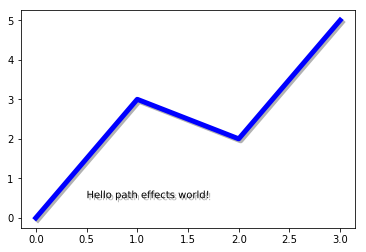

In [78]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

text = plt.text(0.5, 0.5, 'Hello path effects world!',
                path_effects=[path_effects.withSimplePatchShadow()])

plt.plot([0, 3, 2, 5], linewidth=5, color='blue',
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.show()